/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


2020-03-30, (MA Period ?) Ending Value 100000.00


Start date,2018-10-01
End date,2020-03-30
Total months,17
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2018-10-01,2018-10-01,2018-10-01,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


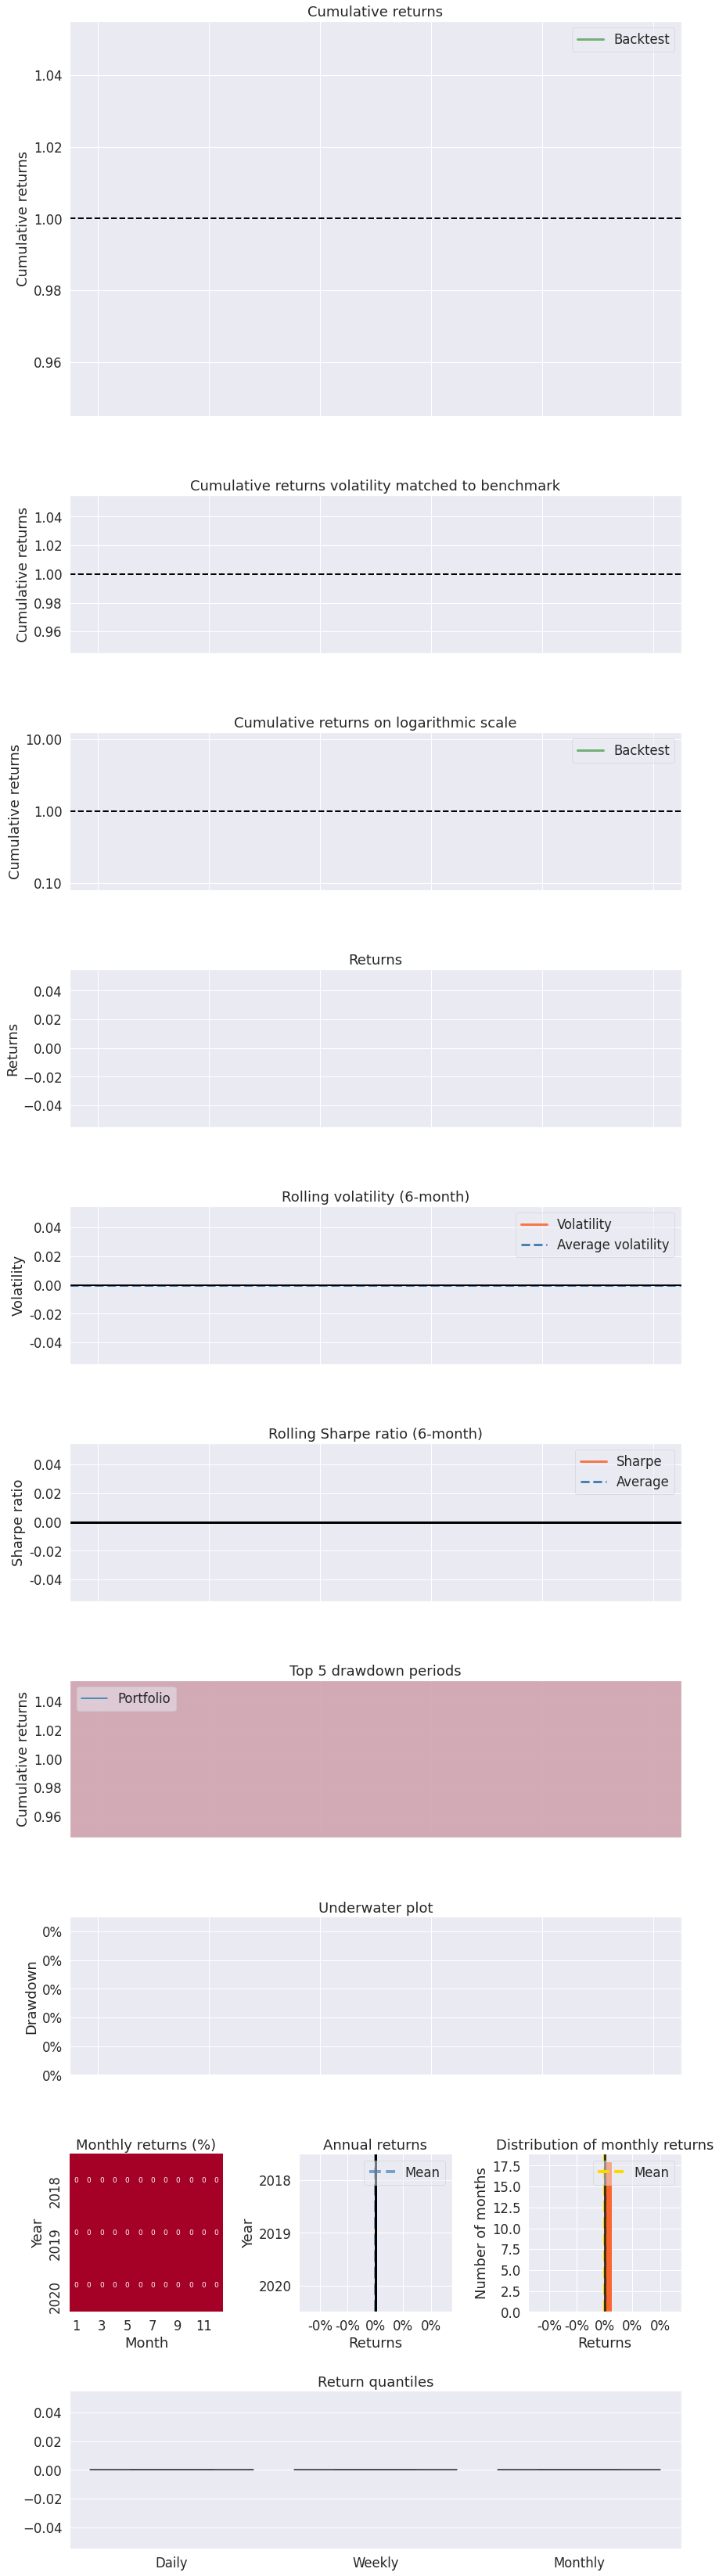

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import datetime
import os.path
import sys
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import pyfolio as pf
import datetime
import backtrader.feeds as btfeed
import pandas as pd
from strategies.crossover_9_21_with_swing import Crossover9_21WithSwing
import warnings; warnings.simplefilter('ignore')

all_option_data_october = pd.read_csv('./data/options_data/monthly_data/SPY_20181001_to_20181031.csv', parse_dates=True, index_col=7)

def create_data_feed(pd_data, series_name):
#     print(series_name)
    option_feed = bt.feeds.PandasData(
        dataname=pd_data,
        fromdate=datetime.datetime(2018, 10, 1),
        todate=datetime.datetime(2018, 10, 31),
        high=None,
        low=None,
        open=9,
        close=11,
        volume=12,
        openinterest=13,
        name=series_name)
    return option_feed

def add_options_data():
    option_types = ['call', 'put']
    option_expirations = all_option_data_october['expiration'].unique()
    option_strikes = all_option_data_october['strike'].unique()
    for type in option_types:
        is_type = all_option_data_october['type'] == 'call'
        filtered_by_type = all_option_data_october[is_type]
        for expiration in option_expirations:
            is_expiration = filtered_by_type['expiration'] == expiration
            filtered_by_type_expiration = filtered_by_type[is_expiration]
            for strike in option_strikes:
                is_strike = filtered_by_type_expiration['strike'] == strike
                filtered_by_type_expiration_strike = filtered_by_type_expiration[is_strike]
                if not filtered_by_type_expiration_strike.empty:
                    series_name = type + "_" + str(strike) + "_" + str(expiration)
                    single_option_data = create_data_feed(filtered_by_type_expiration_strike, series_name)
                    cerebro.adddata(single_option_data)

cerebro = bt.Cerebro()
cerebro.addstrategy(Crossover9_21WithSwing, printlog=False)

underlying = bt.feeds.YahooFinanceCSVData(
    dataname='./data/SPY.csv',
    fromdate=datetime.datetime(2018, 10, 1),
    todate=datetime.datetime(2020, 3, 31),
    reverse=False)

cerebro.adddata(underlying)
add_options_data()
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=1)
cerebro.broker.setcommission(commission=0.0)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_full_tear_sheet(returns)
